## Test Kinematic Inconsistency
Questo blocco di codice iniziale serve come piattaforma di configurazione e caricamento per la valutazione dell'efficacia del modello LNN nel rilevare attacchi cinematici.

1. **Preparazione degli Strumenti Analitici e di Misurazione.**
    Il codice importa un set di librerie focalizzate sulla valutazione della performance dove troviamo le metriche standard di machine learning.

2. **Ottimizzazione e Caricamento dei Componenti.**
   Viene eseguita l'ottimizzazione dell'hardware (GPU e Mixed Precision) per garantire che la fase di test sia rapida ed efficiente.
   
3. **Definizione del Contesto Operativo.**
   Vengono riconfermati i parametri strutturali del modello (WINDOW_SIZE, BATCH_SIZE e le quattro feature dinamiche) e, crucialmente, viene identificato il set di File di Test.  
   
   Questi file sono la base sperimentale. Su queste traiettorie originali (mai viste dal modello), verrà iniettato l'attacco cinematico. Il modello, che è stato addestrato solo sulla normalità, elaborerà queste traiettorie alterate.

In [1]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq

# Import LNN
from ncps.tf import CfC
from ncps.wirings import AutoNCP
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, RepeatVector
from tensorflow.keras import mixed_precision

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Config GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError: pass

WINDOW_SIZE = 30
BATCH_SIZE = 256
COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset_Ready_For_AI_FINAL'
SCALER_PATH = 'scaler.joblib'
WEIGHTS_PATH = 'lnn_autoencoder_best.weights.h5'

# LNN Params
RECURRENT_UNITS = 128
BOTTLENECK_SIZE = 64

print("Configurazione Kinematic Test completata.")

Configurazione Kinematic Test completata.


####  Definizione delle Funzioni del Data Generator
Questo blocco definisce le due funzioni essenziali per trasformare i dati grezzi in sequenze pronte per il modello, mantenendo un'alta efficienza in termini di memoria (RAM)

In [2]:
def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
             # Shuffle disattivato forzatamente per garantire la sequenzialità
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        # Se la traiettoria tocca la fine del chunk, bufferizzala
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue
print("Funzioni definite")

Funzioni definite


### Ricostruzione del Modello e Preparazione Pipeline Dati
In questa fase operativa, ripristiniamo l'intelligenza artificiale addestrata e prepariamo il flusso di dati per il test. Poiché stiamo lavorando con layer custom (ncps), la procedura è divisa in tre step precisi:

1. **Caricamento dello Scaler**: Carichiamo lo `scaler.joblib` originale. È vitale usare esattamente la stessa media e deviazione standard del training. 

2. **Ricostruzione dell'Architettura LNN:** Poiché abbiamo salvato solo i pesi, dobbiamo prima ridefinire lo "scheletro" della rete:

3. **Attivazione del Generatore di Test:** Istanziamo test_gen sui file selezionati (TEST_FILES).

   * Impostiamo `shuffle_files=False` per garantire che i dati arrivino in ordine sequenziale, permettendoci di iniettare l'attacco su traiettorie specifiche e monitorare l'effetto fotogramma per fotogramma.

In [3]:
scaler = joblib.load(SCALER_PATH)
all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
TEST_FILES = all_files[20:24]

print("Ricostruzione LNN")
wiring = AutoNCP(RECURRENT_UNITS, output_size=BOTTLENECK_SIZE)
inputs = Input(shape=(WINDOW_SIZE, 4))
lnn_encoder = CfC(wiring, return_sequences=False, mixed_memory=True)(inputs)
repeat_vector = RepeatVector(WINDOW_SIZE)(lnn_encoder)
lnn_decoder = CfC(wiring, return_sequences=True, mixed_memory=True)(repeat_vector)
output = TimeDistributed(Dense(4))(lnn_decoder)
model = Model(inputs, output)

model.load_weights(WEIGHTS_PATH)
print("Pesi LNN caricati.")
test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE, shuffle_files=False)

Ricostruzione LNN


I0000 00:00:1764679573.640352   44866 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3521 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Pesi LNN caricati.


### Funzione di Attacco Cinematico
La funzione `apply_kinematic_attack `prende un batch di traiettorie normali e introduce un'anomalia istantanea, creando un'incoerenza fisica tra la posizione dichiarata e i parametri di movimento dinamico della nave.
Un attacco cinematico simula un errore o una manipolazione nel segnale GPS/AIS (Automatic Identification System) della nave. L'attacco non modifica la rotta o la velocità in modo graduale e realistico, ma introduce una discontinuità istantanea nella posizione. Il modello LSTM Autoencoder è stato addestrato per apprendere proprio questa relazione fisica coerente. Quando la rete vede una posizione che "salta" senza che la velocità e la rotta cambino in modo corrispondente, l'errore di ricostruzione sarà altissimo.
La funzione crea l'attacco agendo direttamente sui dati normalizzati:

1. **Copia e Inizio Attacco:** La funzione crea una copia dei dati puliti `(batch_clean.copy())` per non alterare l'originale. L'attacco viene fatto partire dal timestep 15 `(attack_start_idx)`, ovvero a metà della finestra temporale di 30 step.

2. **Iniezione del Salto di Posizione:**
   * `batch_attacked[:, attack_start_idx:, 0] += shift_magnitude`(Latitudine) 
   * `batch_attacked[:, attack_start_idx:, 1] += shift_magnitude` (Longitudine)
      * Questo è il cuore dell'attacco: Viene aggiunto un offset costante `shift_magnitude` a tutti i punti successivi al timestep 15. Questo crea un **"gradino"** istantaneo nel segnale della posizione, simulando un teletrasporto della nave.

3. **Incoerenza Vettoriale:** La parte cruciale dell'attacco è che i parametri dinamici (Velocità $\text{SOG}$ e Rotta $\text{COG}$, indici 2 e 3) non vengono modificati.

L'output della funzione è un batch di traiettorie che mostrano: posizione saltata $\cap$ dinamica inspiegabilmente coerente, creando esattamente l'anomalia che il modello LNN è stato addestrato a riconoscere.

In [4]:
def apply_kinematic_attack(batch_clean, attack_start_idx=15, shift_magnitude=2.0):

    #batch_clean: Batch di dati normalizzati
    #attack_start_idx: A quale step inizia l'attacco (15 è metà finestra)
    #shift_magnitude: Di quanto spostare (in deviazioni standard)
    
    batch_attacked = batch_clean.copy()
    
    # Aggiungiamo un offset costante (simuliamo un salto istantaneo)
    # Questo crea un "gradino" impossibile nella posizione
    batch_attacked[:, attack_start_idx:, 0] += shift_magnitude # Sposta Lat
    batch_attacked[:, attack_start_idx:, 1] += shift_magnitude # Sposta Lon
    
    # non modifichiamo SOG e COG (indici 2 e 3). 
    # È qui l'incoerenza perchè la posizione cambia, ma la velocità non lo giustifica.
    
    return batch_attacked
print("Funzione di attacco definita.")

Funzione di attacco definita.


### Creazione del dataset misto
E' stato scelto di attaccare metà dataset.

In [13]:
# Creiamo il dataset misto
X_test_mixed = []
y_true = [] # 0 = Normale, 1 = Attacco

# Prendiamo NUM_BATCHES batch dal generatore
NUM_BATCHES = 1000

for _ in range(NUM_BATCHES):
    #Prendi dati puliti
    clean_batch, _ = next(test_gen)
    
    #Crea la versione attaccata
    attacked_batch = apply_kinematic_attack(clean_batch, shift_magnitude=3.0) # Attacco forte
    
    #Aggiungi alla lista
    #Aggiungiamo metà puliti
    half = len(clean_batch) // 2
    X_test_mixed.append(clean_batch[:half])
    y_true.extend([0] * half) # Etichetta 0
    
    #Aggiungiamo metà attaccati
    X_test_mixed.append(attacked_batch[half:])
    y_true.extend([1] * (len(clean_batch) - half)) #Etichetta 1

# Concateniamo tutto in un unico array numpy
X_test_mixed = np.concatenate(X_test_mixed)
y_true = np.array(y_true)

print(f"Dataset creato: {X_test_mixed.shape}")
print(f"Campioni Normali: {np.sum(y_true == 0)}")
print(f"Campioni Attaccati: {np.sum(y_true == 1)}")

Dataset creato: (256000, 30, 4)
Campioni Normali: 128000
Campioni Attaccati: 128000


### Calcolo degli Errori di Rilevamento
Si sottopone il modello addestrato ai dati contenenti l'attacco cinematico. Come metrica chiave calcoliamo il $\text{MAE}$


In [14]:
print("Esecuzione predizioni sul dataset misto...")
reconstructions = model.predict(X_test_mixed, verbose=1)

# Calcoliamo l'errore MAE 
mae_per_sample = np.mean(np.abs(X_test_mixed - reconstructions), axis=(1, 2))

print(f"Calcolo errori completato")

Esecuzione predizioni sul dataset misto...
8000/8000 [==============================] - 278s 35ms/step
Calcolo errori completato


### Istogramma Comparativo
In questo grafico confrontiamo le distribuzioni dell'errore (MAE) per i due gruppi di traiettorie: quelle normali (verdi) e quelle attaccate (rosse).

  * **Dati Normali (Verde)**: Si osserva un picco molto stretto e alto vicino a MAE 0.00. Questo conferma che il modello LNN ricostruisce le traiettorie fisicamente coerenti con estrema precisione. La coda della distribuzione verde si esaurisce rapidamente, indicando che raramente commette errori significativi su dati leciti.

  * **Dati Attaccati (Rosso)**: La distribuzione rossa è nettamente spostata verso destra, con un picco intorno a **MAE 0.8.** Questo valore è enormemente più alto dell'errore normale. Questo perchè quando la rete prova a ricostruire il "salto impossibile", fallisce miseramente perché la sua memoria liquida non permette cambiamenti di stato istantanei. Questo fallimento genera un errore massiccio.


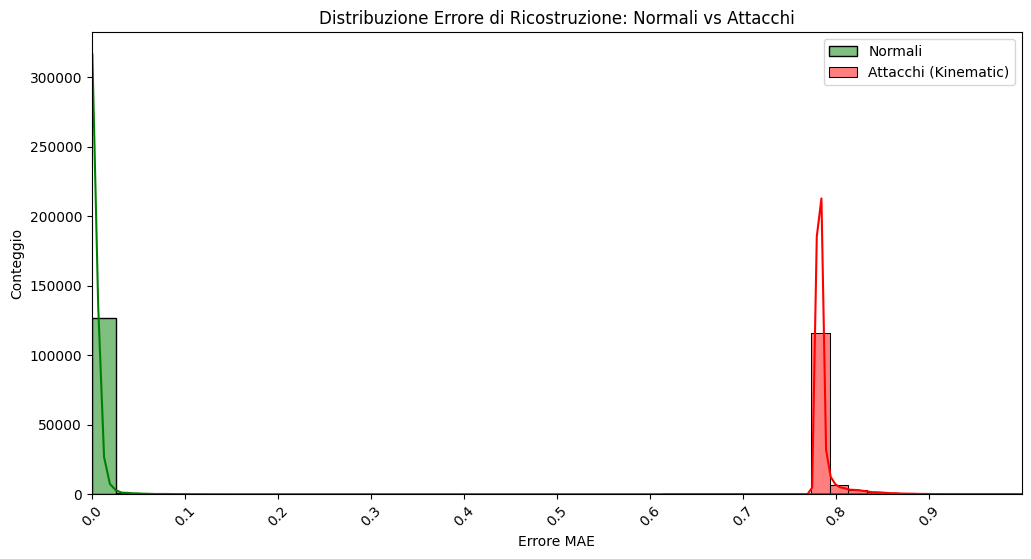

In [15]:
plt.figure(figsize=(12, 6))

# Istogramma Normali (Verde)
sns.histplot(mae_per_sample[y_true == 0], color='green', label='Normali', kde=True, bins=50, alpha=0.5)

# Istogramma Attacchi (Rosso)
sns.histplot(mae_per_sample[y_true == 1], color='red', label='Attacchi (Kinematic)', kde=True, bins=50, alpha=0.5)

plt.xlim(0, 1.0)
plt.xticks(np.arange(0, 1.0, 0.1), rotation=45)

plt.title("Distribuzione Errore di Ricostruzione: Normali vs Attacchi")
plt.xlabel("Errore MAE")
plt.ylabel("Conteggio")
plt.legend()
plt.show()

### Valutazione Quantitativa e Matrice di Confusione
1. **Definizione della Soglia** ($3\sigma$ Rule): Calcoliamo la soglia di allarme basandoci solo sui dati normali. Utilizziamo la regola statistica: $\text{Threshold} = \mu + 3\sigma$. Questo significa che impostiamo l'asticella così in alto che solo lo 0.3% dei dati normali potrebbe superarla per errore. È una scelta conservativa per minimizzare i falsi allarmi. Il **TRESHOLD** è di $\mathbf{0.0527}$

2. **Classificazione e Calcolo delle Metriche**
   * Viene eseguita la classificazione binaria: se l'errore $\text{MAE}$ del campione supera la **THRESHOLD**, il sistema predice un Attacco (1); altrimenti, predice Normale (0).
   * **Metriche Calcolate:** 
     * $\mathbf{Accuracy} \approx 0.9972$ (99.72% di tutte le classificazioni sono corrette).
     * $\mathbf{Precision} \approx 0.9944$ (Quando il modello dice "Attacco", ha ragione nel 99.44% dei casi).
     * $\mathbf{Recall} = 1.0000$ (Il modello ha trovato il 100% di tutti gli attacchi reali presenti nel set).
     * $\mathbf{F1-Score} \approx 0.9972$ (La media armonica di Precision e Recall, un ottimo indicatore della performance complessiva).

3. **Analisi della Matrice di Confusione**
   * **True Positives (128,000):** Il modello ha identificato correttamente tutti i campioni che contenevano l'attacco cinematico.
   * **True Negatives (127,280):** Il modello ha classificato correttamente la stragrande maggioranza dei campioni normali.
   * **False Negatives (0):** Non c'è stato nessun falso negativo. 
   * **False Positives (720):** Ci sono stati solo 720 falsi positivi

Soglia rilevamento calcolata (Mean + 3*Std): 0.0420

--- RISULTATI CLASSIFICAZIONE ---
Accuracy:  0.9972
Precision: 0.9944
Recall:    1.0000
F1-Score:  0.9972


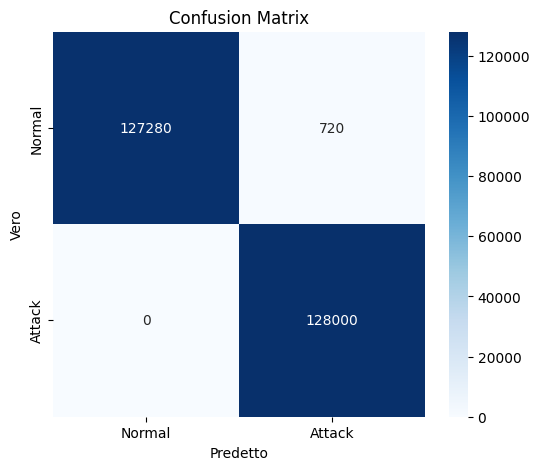

In [16]:
# Definiamo la soglia (Threshold)
errori_normali = mae_per_sample[y_true == 0]
THRESHOLD = np.mean(errori_normali) + 3 * np.std(errori_normali)
print(f"Soglia rilevamento calcolata (Mean + 3*Std): {THRESHOLD:.4f}")

# Classificazione --> Se errore > soglia -> È un attacco (1)
y_pred = (mae_per_sample > THRESHOLD).astype(int)

# Metriche
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n--- RISULTATI CLASSIFICAZIONE ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Matrice di Confusione
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title("Confusion Matrix")
plt.ylabel("Vero")
plt.xlabel("Predetto")
plt.show()

### Visualizzazione di un singolo attacco
Il codice estrae un campione specifico di traiettoria a cui è stato applicato l'attacco cinematico e traccia su un grafico 2D (Latitudine vs Longitudine) sia l'input manipolato che il tentativo del modello di ricostruirlo.

**Analisi del grafico:**
   * **Input Attaccato (Linea Blu):** La traiettoria è una linea retta diagonale enorme e innaturale. Questo è il "salto netto" o teletrasporto. La nave si sposta di centinaia di chilometri in pochi minuti, violando palesemente le leggi della fisica (un cambio di posizione senza velocità adeguata).

   * **Ricostruzione del Modello (Linea Rossa):** Il modello non riesce a replicare il salto perchè quando l'Encoder riceve il salto impossibile, il Decoder tenta di generare una sequenza che sia fisicamente plausibile e simile a quelle viste nel training. Non potendo "teletrasportarsi", la LNN collassa e produce una ricostruzione locale, ignorando totalmente la vasta escursione dell'input.

   * **Risultato**: La discrepanza tra la linea blu (input impossibile) e la linea rossa (fisica appresa) è gigantesca. Questa differenza genera l'errore di ricostruzione elevatissimo (MAE > 0.7) che fa scattare l'allarme.

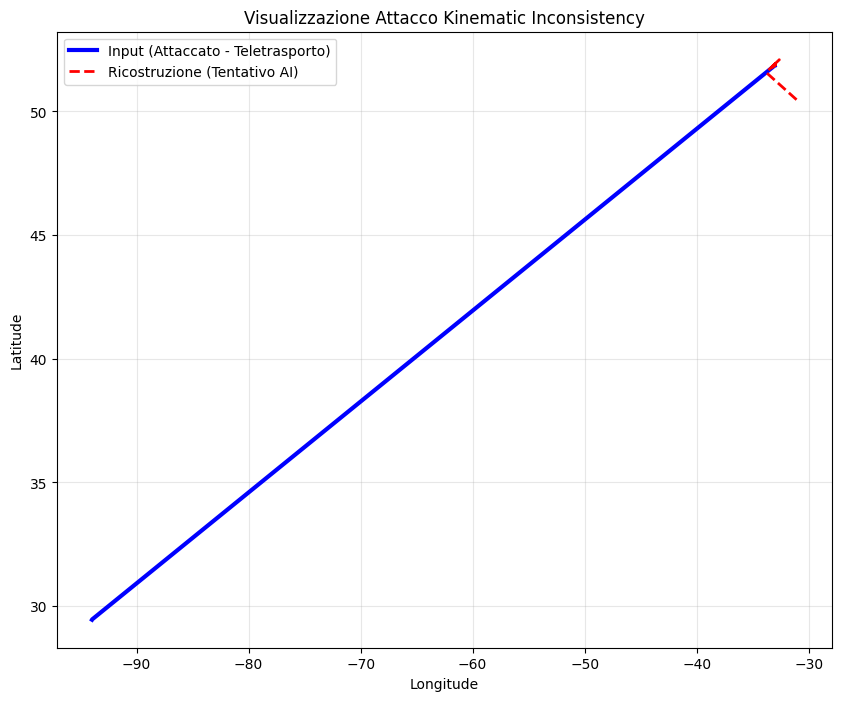

In [17]:
# Troviamo un esempio di attacco rilevato
attack_indices = np.where(y_true == 1)[0]
idx = attack_indices[0] # Il primo attacco

real_input = X_test_mixed[idx] # Questo è quello corrotto
reconstructed = reconstructions[idx] # Questo è quello che la rete ha provato a fare

# Denormalizziamo per il plot 2D
real_phys = scaler.inverse_transform(real_input)
recon_phys = scaler.inverse_transform(reconstructed)

plt.figure(figsize=(10, 8))
plt.plot(real_phys[:, 1], real_phys[:, 0], 'b-', label='Input (Attaccato - Teletrasporto)', linewidth=3)
plt.plot(recon_phys[:, 1], recon_phys[:, 0], 'r--', label='Ricostruzione (Tentativo AI)', linewidth=2)
plt.title("Visualizzazione Attacco Kinematic Inconsistency")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()